In [2]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import colormaps as cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, LAND
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from windspharm.xarray import VectorWind
from windspharm.tools import prep_data, recover_data, order_latdim
import metpy.calc as mpcalc
from metpy.units import units
import pickle

--------------------------------------------------------------------------
but there are no active ports detected (or Open MPI was unable to use
them).  This is most certainly not what you wanted.  Check your
cables, subnet manager configuration, etc.  The openib BTL will be
ignored for this job.

  Local host: gadi-cpu-bdw-0034
--------------------------------------------------------------------------


In [6]:
SWTpath='/home/565/mb0427/gdata-gb02/Australian_synoptic_weather_types/'

In [7]:
with open(SWTpath+'SWT_fields/SWT_WR_definitions.pkl', 'rb') as fp:
    SWTs = pickle.load(fp)

l1 = [SWTs[i]["WR"] for i in SWTs]
WRs = []
s = set()
for i in l1:
   if not i in s:
       WRs.append(i)
       s.add(i)

regime_clusters={}
for WR in WRs:
    regime_clusters[WR]=[]
    for i in SWTs:
        if SWTs[i]["WR"]==WR:
            regime_clusters[WR].append(i)

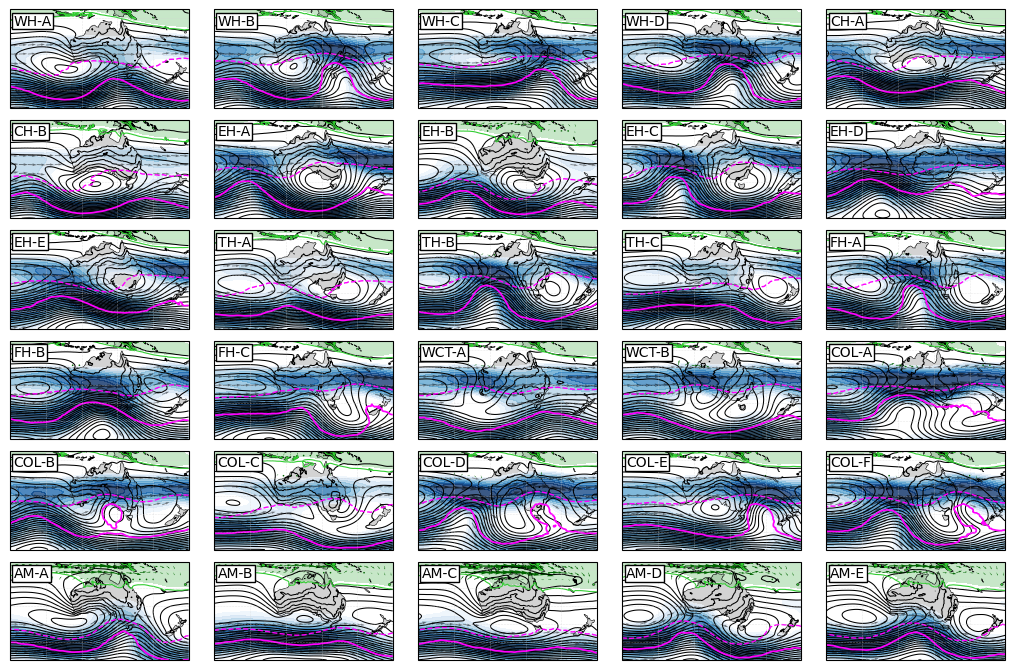

In [9]:
plot_extent=[80,180,-60,-5]
figsize=(11,8)
fig, axs = plt.subplots(6, 5, figsize=figsize, subplot_kw=dict(projection=ccrs.PlateCarree())) 
ax_list=axs.reshape(-1)

for i,code in enumerate(SWTs):
    SWT=SWTs[code]
    WR=SWT["WR"]
    SWTcode=SWT["SWT"]
    #innewname = fr"${WR}_{{{SWTcode}}}$"
    innewname = WR+"-"+SWTcode #fr"${WR}-{SWTcode}$"
    inname = "Cluster"+str(code)
    infile=SWTpath+'example_data/'+'Composite_ERA5_SWT_'+inname+'.nc'
    dsMSL=xr.open_dataset(infile).msl
    dsPV315=xr.open_dataset(infile).pv315
    dsPV330=xr.open_dataset(infile).pv330
    dsU850=xr.open_dataset(infile).u850
    dsV850=xr.open_dataset(infile).v850
    dsU=xr.open_dataset(infile).u300
    dsV=xr.open_dataset(infile).v300
    dsTCWV=xr.open_dataset(infile).tcwv
    
    spd300=mpcalc.wind_speed(dsU * units('m/s'), dsV  * units('m/s')).metpy.dequantify()
    ujet300=dsU.where(spd300>40*0.514444)
    vjet300=dsV.where(spd300>40*0.514444)
    jet300=spd300.where(spd300>35*0.514444)

    uW850=dsU850.where(dsU850>0).sel(latitude=slice(0,-20))
    vW850=dsV850.where(dsU850>0).sel(latitude=slice(0,-20))
    
    ax=ax_list[i]
    ax.set_extent(plot_extent,crs=ccrs.PlateCarree())

    ax.add_feature(LAND,facecolor='lightgrey')
    ax.coastlines(linewidths=0.4)
    
    plot_levels = list(range(900,1060,2))
    c=ax.contour(dsMSL.longitude,dsMSL.latitude,dsMSL,
                     levels=plot_levels,colors='black',linewidths=0.75,linestyles='-',
                     transform=ccrs.PlateCarree())
    
    plot_levels = range(35,80,5)
    cf=ax.contourf(jet300.longitude,jet300.latitude,jet300*1.94384,
                   levels=plot_levels,cmap='Blues',extend='max',
                   transform=ccrs.PlateCarree(),alpha=0.75)

    plot_levels = range(48,1000,500)
    cf=ax.contourf(dsTCWV.longitude,dsTCWV.latitude,dsTCWV,
                   levels=plot_levels,cmap='Greens',extend='max',
                   transform=ccrs.PlateCarree(),alpha=0.4)
    
    c=ax.contour(dsTCWV.longitude,dsTCWV.latitude,dsTCWV,
                     levels=[45],colors='limegreen',linewidths=0.8,linestyles='-',
                     transform=ccrs.PlateCarree())
    
    nvec=15
    q=ax.quiver(uW850.longitude[::nvec],uW850.latitude[::nvec], 
                 uW850[::nvec,::nvec], vW850[::nvec,::nvec],
                  scale=1,scale_units='xy',width=0.01,minshaft=2,color='darkgreen',# minlength=1,
                  transform=ccrs.PlateCarree())
    nvec=20
    q=ax.quiver(jet300.longitude[::nvec],jet300.latitude[::nvec], 
                 ujet300[::nvec,::nvec], vjet300[::nvec,::nvec],
                  scale=5,scale_units='xy',width=0.01,minshaft=2,# minlength=1,
                  transform=ccrs.PlateCarree(), alpha=0.5)

    c=ax.contour(dsPV330.longitude,dsPV330.latitude,dsPV330*1e6,
                     levels=[-2],colors='magenta',linewidths=1.0,linestyles='--',
                     transform=ccrs.PlateCarree())
    c=ax.contour(dsPV315.longitude,dsPV315.latitude,dsPV315*1e6,
                     levels=[-2],colors='magenta',linewidths=1.25,linestyles='-',
                     transform=ccrs.PlateCarree())

    label=ax.text(82,-11.5,innewname,ha='left',va='center',fontsize=10,
                          bbox=dict(boxstyle='square,pad=0.1', fc='white', ec='black'))
    
    gl = ax.gridlines(transform=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.4, color='lightgrey', alpha=0.5, linestyle='--')
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.top_labels = False
    gl.right_labels = False
    gl.bottom_labels = False
    gl.left_labels = False

fig.tight_layout(pad=0.4)
fig.subplots_adjust(left=0.065, right=0.97, top=0.94, bottom=0.11, wspace=0.14)

plt.show()